# Graph Machine Learning

This practical work is devoted to the discovery of graph machine learning using Graph Neural Network, on a simple and classic classification experiment, namely the [MUTAG dataset](). 

Before starting to work, we will check that our kernel configuration is ok. Execute the next cell, you should have no error. 

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

2.3.1+cu121


## Dataset Loading

Exploration du dataset, affichage des graphes, présentation de la problématique, check des labels. Insister sur le fait que ce soit un pb de classif de graphes et non de noeuds

The MUTAG dataset is a classic classification dataset used in graph machine learning. It consists of a collection of mutagenic aromatic and heteroaromatic nitro compounds. The goal is to predict whether a compound is mutagenic or non-mutagenic based on its molecular structure.

The dataset contains a set of graphs, where each graph represents a compound. Each node in the graph represents an atom in the compound, and the edges represent the bonds between atoms. The nodes carry the atom types as attributes and the edges the kind of atomic bond.

The dataset is labeled, with each graph labeled as either mutagenic or non-mutagenic. This makes it a binary graph classification problem.

The following code imports the `TUDataset` class from `torch_geometric.datasets` module and creates an instance of the dataset by specifying the root directory where the data will be locally stored.

In [2]:
from torch_geometric.datasets import TUDataset


dataset_path = "data/TUDataset"
dataset = TUDataset(root=dataset_path, name='MUTAG')

dataset.download()

Extracting data/TUDataset/MUTAG/MUTAG.zip


### Data exploration

By looking, at the size of the dataset, we can retrieve the number of compounds. Each item in the dataset corresponds to a graph, and each item of `dataset.y` corresponds to the class of the compound.

In [3]:
print(len(dataset))

188


In [4]:
graph = dataset[0]
print(graph)

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


To visualize a molecule, we can rely on `networkx` library. Note that nodes attributes encode the atom type as a one hot encoding, the same with edge attributes and kind of atomic bond.

What are the possible node's and edge's labels ? How many nodes for the first graph ? 

In [ ]:
from torch_geometric.utils import to_networkx
g = to_networkx(graph, node_attrs='x')
nx.draw(g, with_labels=True)


The first graph has 17 number of nodes


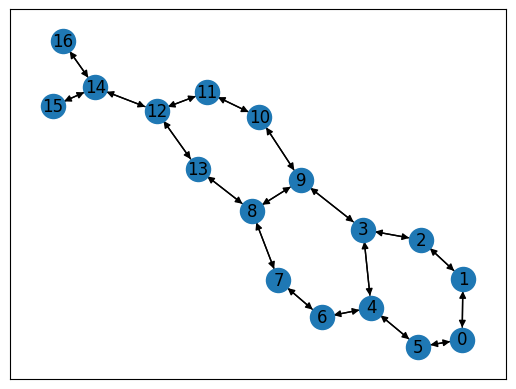

In [5]:
from torch_geometric.utils import to_networkx
g = to_networkx(graph, node_attrs='x')
nx.draw_networkx(g);
print(f"The first graph has {g.number_of_nodes()} number of nodes")

## Pre processing the dataset

rappel de l'importance de séparer train et test, bonne pratique avec pytorch geometric
présentation des dataloader, notion de batch, shuffle oui/non


To make a good model, we want to evaluate its performance on a test set, not used during the learning phase. This separation can be done by keeping by splitting the dataset object using slices of `train_test_split` from scikit-learn library.

Once this separation is performed, we create two dataloaders. The DataLoader class is used to load data in batches during the training and testing phases of a machine learning model. It helps in efficiently processing large datasets by dividing them into smaller batches. 

By using these DataLoader objects, you can iterate over the data in batches during the training and testing phases of your model. This allows you to efficiently process large datasets and train your model more effectively.

In [6]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, train_size=.8, random_state=42) 


In [7]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# check the batch sizes
for data in train_loader:
    print(len(data))

64
64
22


## A first GNN 

To create our first GNN prediction model, we will rely on a model implemented using the Pytorch Geometric library in the `graphadon.py`file. We will first use it as a black box, and then try to understand its components.

![./figures/graph_level.svg](./figures/graph_level.svg)

Create an instance of `FirstGNN` with the default parameters and print the instance.  

In [9]:
%load_ext autoreload
%autoreload 2

from graphadon import FirstGNN

num_node_features = dataset.num_node_features
model = FirstGNN()
print(model)


FirstGNN(
  (conv1): GCNConv(-1, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(64, 2, bias=True)
)


### Model Learning

Once our architecture has been created, we need to tune its parameters to fit a particular task, here our classification task. As a classic MLP or CNN, the learning loop follows the same backbone : 
 1. Forward pass
 1. Gradient computation
 1. Backward pass
 1. Reinitialisation of gradients.

Complete the following code to learn the parameters of our `FirstGNN`.
For each epoch, compute the loss and the accuracy performance on train set. 



In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

NB_EPOCHS = ...

for epoch in tqdm(range(1, NB_EPOCHS+1)):
    model.train()
    for data in train_loader:  # Pour chaque mini batch
        # forward pass. What the GNN need to perform the forward pass ?
        out = model.forward(data.x, data.edge_index, data.batch) 
        loss = criterion(out, data.y)   # calcul de la loss
        loss.backward()  #calcul des gradients  
        
        
        optimizer.step()  # Rétro propagation 
        optimizer.zero_grad()  # on remet à 0 pour le prochain tour
    
    model.eval()
    # test de l'accuracy sur le train 
    for data in train_loader: 
        out = model.forward(data.x, data.edge_index, data.batch) 
        pred = out.argmax(dim=1) # décider de qui a gagné
    accuracy = ...
    


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

NB_EPOCHS = 200

for epoch in tqdm(range(1, NB_EPOCHS+1)):
    model.train()
    cur_loss = 0
    for data in train_loader:  # Pour chaque mini batch
        out = model.forward(data.x, data.edge_index, data.batch)  # forward pass
        loss = criterion(out, data.y)   # calcul de la loss
        loss.backward()  #calcul des gradients  
        cur_loss += loss.item()
        
        optimizer.step()  # Rétro propagation 
        optimizer.zero_grad()  # on remet à 0 pour le prochain tour
    losses.append(cur_loss)
    
    # on teste la perf en accuracy
    model.eval()
    correct = 0
    for data in train_loader: 
        out = model.forward(data.x, data.edge_index, data.batch) 
        pred = out.argmax(dim=1) # décider de qui a gagné
        correct += int((pred == data.y).sum())
    accuracy = correct / len(train_dataset)
    accuracies.append(accuracy)
    
a

100%|██████████| 200/200 [00:08<00:00, 24.93it/s]


### Learning curves

To be sure that everything went well, plot the learning curves according to the loss and the accuracy on train set.

Are the curves following your expectations ? 


0.7866666666666666


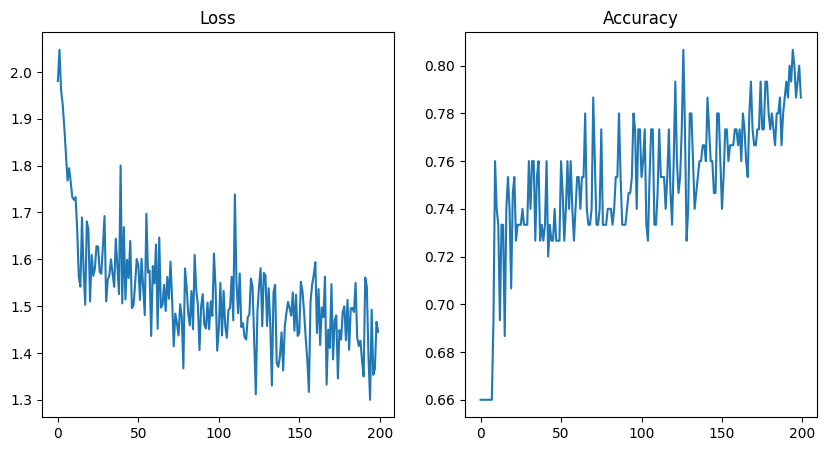

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(losses)
axes[0].set_title("Loss")
axes[1].plot(accuracies)
axes[1].set_title("Accuracy")
print(accuracies[-1])

### Prediction

For now, we only check the performance on data we already know the properties, which is quite useless. Let's evaluate our model on test set. 

Compute the accuracy on test set and compare it to the accuracy on train set. 

What's your opinion on the computed value ? 



* train set c'est tricher, testons sur l'ensemble (petit) de test
* Il faudrait moyenner en refaisant des tirages train/test
* si perf test > perf train, augmenter la complexité du modele et/ou le nb d'epochs 


In [ ]:
model.eval() # utile pour les dropout 

for data in test_loader:  
    ...
acc = ...
print('Accuracy: {:.4f}'.format(acc))

In [13]:
model.eval() # utile pour les dropout 
correct = 0
for data in test_loader:  
    out = model.forward(data.x, data.edge_index, batch=data.batch)  
    pred = out.argmax(dim=1)  # décider de qui a gagné
    correct += (data.y == pred).sum().item() 
acc = correct / len(test_dataset)
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8421


# Add a validation set

Let's now evaluate the performance on our test set (which hence becomes a validation set) for each epoch. 

1. Complete the function test to get the accuracy of a pair of model/dataloader
2. Modify your learning curve to compute accuracy on both learning/validation set
3. Draw the learning curves 
 

In [ ]:
def test(model, loader):
    """Compute the accuracy on loader using model"""
    acc = ...
    return correct / len(loader.dataset)  

In [14]:
def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)  

In [15]:
from graphadon import FirstGNN

num_node_features = dataset.num_node_features
model = FirstGNN(in_channels=num_node_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

losses = []
accs_train = []
accs_test =  []

NB_EPOCHS = 200

for epoch in tqdm(range(1, NB_EPOCHS)):
    accs_train.append(test(model, train_loader))
    accs_test.append(test(model, test_loader))
    
    model.train()
    cur_loss = 0
    for data in train_loader:
        out = model.forward(data.x, data.edge_index, batch=data.batch)  
        loss = criterion(out, data.y)  
        loss.backward()
        cur_loss += loss.item()
        optimizer.step() 
        optimizer.zero_grad() 
    losses.append(cur_loss)


100%|██████████| 199/199 [00:11<00:00, 16.78it/s]


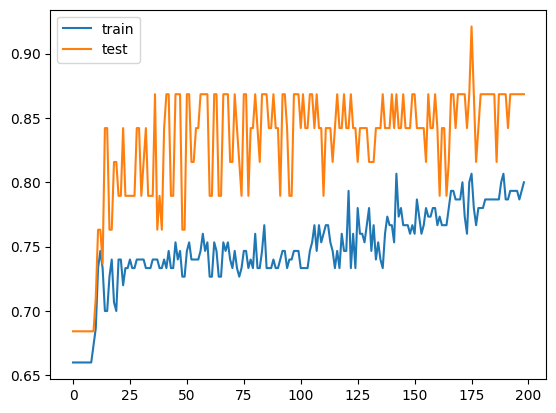

In [16]:
plt.plot(accs_train, label="train")
plt.plot(accs_test, label="test")
plt.legend()
# encore besoin de training ! 

## GNN Implementation

Now we are able to train a predictive model as a black box, let's go into details and analyze how this GNN is built. 

### Layer Analysis

1. Open the file `graphadon.py` and analyse the contents of the `FirstGNN` class. What layers do you identify ?
> Note that you can heavily rely on the documentation of `pytorch geometric` : [https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html]()

2. Add a convolutional layer followed by a ReLU. 
> Congrats ! You implemented your first GNN, now you can test it. 


100%|██████████| 999/999 [00:59<00:00, 16.91it/s]


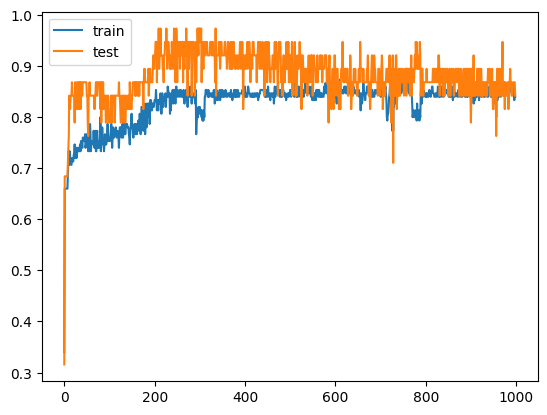

In [34]:
from graphadon import SecondGNN

num_node_features = dataset.num_node_features
model = SecondGNN(in_channels=num_node_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

losses = []
accs_train = []
accs_test =  []

NB_EPOCHS = 1000

for epoch in tqdm(range(1, NB_EPOCHS)):
    accs_train.append(test(model, train_loader))
    accs_test.append(test(model, test_loader))
    
    model.train()
    cur_loss = 0
    for data in train_loader:
        out = model.forward(data.x, data.edge_index, batch=data.batch)  
        loss = criterion(out, data.y)  
        loss.backward()
        cur_loss += loss.item()
        optimizer.step() 
        optimizer.zero_grad() 
    losses.append(cur_loss)


plt.plot(accs_train, label="train")
plt.plot(accs_test, label="test")
plt.legend()



### So many convolutions 

Change the convolutional layers to  `GraphConv` and test your new model. 

You can also pick among the many layers available : https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers



100%|██████████| 99/99 [00:03<00:00, 32.07it/s]


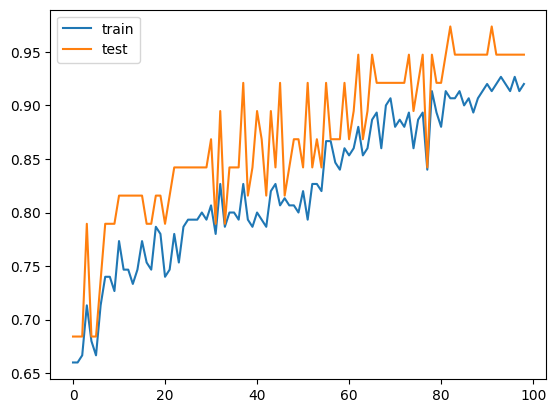

In [35]:
from graphadon import ThirdGNN

num_node_features = dataset.num_node_features
model = ThirdGNN(in_channels=num_node_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

losses = []
accs_train = []
accs_test =  []

NB_EPOCHS = 100

for epoch in tqdm(range(1, NB_EPOCHS)):
    accs_train.append(test(model, train_loader))
    accs_test.append(test(model, test_loader))
    
    model.train()
    cur_loss = 0
    for data in train_loader:
        out = model.forward(data.x, data.edge_index, batch=data.batch)  
        loss = criterion(out, data.y)  
        loss.backward()
        cur_loss += loss.item()
        optimizer.step() 
        optimizer.zero_grad() 
    losses.append(cur_loss)


plt.plot(accs_train, label="train")
plt.plot(accs_test, label="test")
plt.legend()

### Readout/Pooling

In the first GNN implemented, we inserted a `global_mean_pooling` layer. 

1. What is the rationale of this function ? What happen if we remove it ? 
2. Change this function to another readout strategy and test the new model.


  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:49<00:00, 20.35it/s]


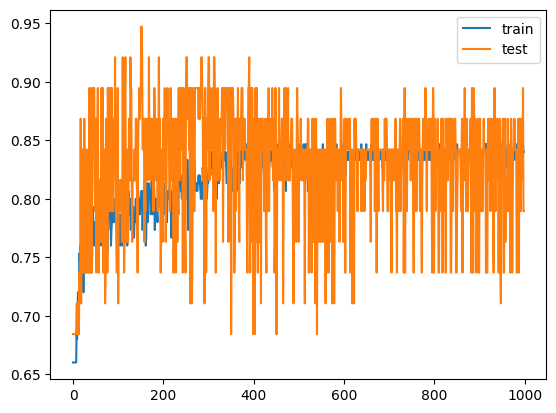

In [36]:
from graphadon import FourthGNN

num_node_features = dataset.num_node_features
model = FourthGNN(in_channels=num_node_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

losses = []
accs_train = []
accs_test =  []

NB_EPOCHS = 1000

for epoch in tqdm(range(1, NB_EPOCHS)):
    accs_train.append(test(model, train_loader))
    accs_test.append(test(model, test_loader))
    
    model.train()
    cur_loss = 0
    for data in train_loader:
        out = model.forward(data.x, data.edge_index, batch=data.batch)  
        loss = criterion(out, data.y)  
        loss.backward()
        cur_loss += loss.item()
        optimizer.step() 
        optimizer.zero_grad() 
    losses.append(cur_loss)


plt.plot(accs_train, label="train")
plt.plot(accs_test, label="test")
plt.legend()

#not great with max pooling :(


### Hyperparameters

GNNs architectures open a lot of new possibilities but they come with a strong drawback : tuning hyperaparemeters.

1. Identify the hyperparameters for the different layers, the model itself and the optimization algorithm.

2. Propose a strategy to find the best combination 



nb de couches, type de couche, dimensions des couches, type de readout(s), nb epochs, patience,  taille de batch, etc.

En gros, beaucoup d'hyperparametres, compliqué avec un grid search. Donc il faut sélectionner les hyperparametres à tester et se donner un budget. En résumé, problème compliqué sans solution tranchée.

se reférer à : Errica, F., Podda, M., Bacciu, D., & Micheli, A. (2019). A fair comparison of graph neural networks for graph classification. arXiv preprint arXiv:1912.09893.

## Competition 

Since you are now a new expert on GNNs, let's compete. We created on Kaggle a private leaderboard to test your skills on another dataset encoding molecular compounds : [Kaggle Competition](https://www.kaggle.com/competitions/graphadon-contest)

Here's your invitation link : https://www.kaggle.com/t/aa069d65592d4d15ba457898007e7540

It's still a binary classification task, but now you only have access to the graph of the test set, but not their properties to predict ! 

To compete, you will need to learn a model using the `train_dataset` provided in `train_dataset.pt` file. The submission file for Kaggle competition can be obtained using the `generate_pred_for_kaggle` and `generate_kaggle_file` functions provided in `graphadon.py` file. Check the example using FirstGNN as a source of inspiration.

The train dataset is composed of 2168 molecules, where each node is encoded by 14 binary values corresponding to a one hot encoding of the corresponding atom. Test set is composed of 2169 molecules and encoded in the same way as the train set, except the `y` value.

Do your best ! 

In [17]:
len(test_dataset)

38

In [18]:
# Load the data

train_dataset = torch.load("./train_dataset.pt")
test_dataset = torch.load("./test_dataset.pt")

In [19]:

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


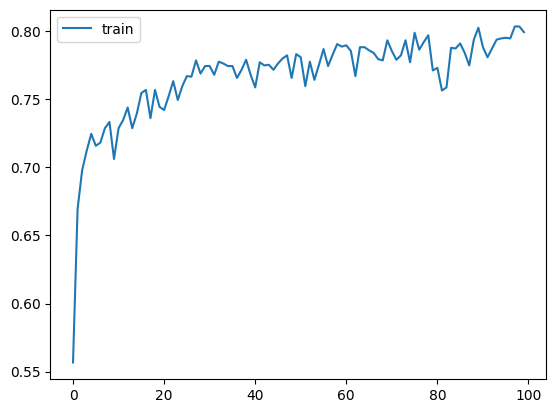

In [20]:
from graphadon import FirstGNN
from graphadon import learn_and_perf

model = FirstGNN()

acc_train, acc_test, losses  = learn_and_perf(model, train_loader, None, nb_epochs=100)

plt.plot(acc_train, label="train")
plt.legend()

In [21]:
from graphadon import generate_pred_for_kaggle, generate_kaggle_file
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
preds = generate_pred_for_kaggle(model, test_loader)
generate_kaggle_file(preds, "./kaggle.csv")
